In [668]:
import random
from typing import Tuple, Dict, List
import numpy as np
import math 
from itertools import permutations
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import nashpy

In [669]:


class KuhnPokerMatrixAnalyzer:
    """
    Analyze Kuhn Poker strategy elimination and matrix reduction
    """
    
    def __init__(self):
        self.cards = ['J', 'Q', 'K']  # 1, 2, 3 in original notation
        self.card_map = {'J': 1, 'Q': 2, 'K': 3}
        self.reverse_card_map = {1: 'J', 2: 'Q', 3: 'K'}
        
    def generate_all_p1_strategies(self):
        """Generate all 27 pure strategies for Player 1"""
        strategies = []
        strategy_names = []
        
        # Each xi can be 0, 1, or 2 (binary: 00, 01, 10)
        for x1 in range(3):
            for x2 in range(3):
                for x3 in range(3):
                    strategy = (x1, x2, x3)
                    strategies.append(strategy)
                    
                    # Create readable name
                    name = f"({x1:02b},{x2:02b},{x3:02b})"
                    strategy_names.append(name)
        
        return strategies, strategy_names
    
    def generate_all_p2_strategies(self):
        """Generate all 64 pure strategies for Player 2"""
        strategies = []
        strategy_names = []
        
        # Each yi can be 0, 1, 2, or 3 (binary: 00, 01, 10, 11)
        for y1 in range(4):
            for y2 in range(4):
                for y3 in range(4):
                    strategy = (y1, y2, y3)
                    strategies.append(strategy)
                    
                    # Create readable name
                    name = f"({y1:02b},{y2:02b},{y3:02b})"
                    strategy_names.append(name)
        
        return strategies, strategy_names
    
    def decode_p1_strategy(self, strategy, card):
        """Decode Player 1 strategy for given card"""
        card_idx = self.card_map[card] - 1  # Convert to 0-indexed
        x_val = strategy[card_idx]
        
        # Convert to binary
        binary = f"{x_val:02b}"
        first_round = int(binary[0])   # 0=pass, 1=bet
        second_round = int(binary[1])  # 0=pass, 1=bet
        
        return first_round, second_round
    
    def decode_p2_strategy(self, strategy, card):
        """Decode Player 2 strategy for given card"""
        card_idx = self.card_map[card] - 1  # Convert to 0-indexed
        y_val = strategy[card_idx]
        
        # Convert to binary
        binary = f"{y_val:02b}"
        vs_pass = int(binary[0])  # 0=pass, 1=bet
        vs_bet = int(binary[1])   # 0=pass, 1=bet
        
        return vs_pass, vs_bet
    
    def calculate_payoff(self, p1_strategy, p2_strategy):
        """Calculate expected payoff for P1 against P2 strategy"""
        total_payoff = 0
        
        # All possible card deals (6 combinations)
        for p1_card in self.cards:
            for p2_card in self.cards:
                if p1_card != p2_card:  # Can't have same card
                    payoff = self.simulate_hand(p1_strategy, p2_strategy, p1_card, p2_card)
                    total_payoff += payoff
        
        return total_payoff  # This is 6 times the actual expected payoff
    
    def simulate_hand(self, p1_strategy, p2_strategy, p1_card, p2_card):
        """Simulate a single hand with given strategies and cards"""
        p1_first, p1_second = self.decode_p1_strategy(p1_strategy, p1_card)
        p2_vs_pass, p2_vs_bet = self.decode_p2_strategy(p2_strategy, p2_card)
        
        # Determine who wins showdown
        p1_wins = self.card_map[p1_card] > self.card_map[p2_card]
        
        if p1_first == 0:  # P1 passes
            if p2_vs_pass == 0:  # P2 passes
                # Showdown for pot of 2
                return 1 if p1_wins else -1
            else:  # P2 bets
                if p1_second == 0:  # P1 folds
                    return -1
                else:  # P1 calls
                    # Showdown for pot of 4
                    return 2 if p1_wins else -2
        else:  # P1 bets
            if p2_vs_bet == 0:  # P2 folds
                return 1
            else:  # P2 calls
                # Showdown for pot of 4
                return 2 if p1_wins else -2
    
    def build_full_matrix(self):
        """Build the complete 27×64 payoff matrix"""
        p1_strategies, p1_names = self.generate_all_p1_strategies()
        p2_strategies, p2_names = self.generate_all_p2_strategies()
        
        matrix = np.zeros((27, 64))
        
        for i, p1_strat in enumerate(p1_strategies):
            for j, p2_strat in enumerate(p2_strategies):
                matrix[i, j] = self.calculate_payoff(p1_strat, p2_strat)
        
        return matrix, p1_strategies, p1_names, p2_strategies, p2_names
    
    def identify_dominated_p1_strategies(self, matrix):
        """Identify dominated P1 strategies (rows)"""
        dominated_rows = []
        
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if i != j:
                    # Check if row i is dominated by row j
                    if np.all(matrix[i, :] <= matrix[j, :]) and np.any(matrix[i, :] < matrix[j, :]):
                        dominated_rows.append(i)
                        break
        
        return list(set(dominated_rows))
    
    def identify_dominated_p2_strategies(self, matrix):
        """Identify dominated P2 strategies (columns)"""
        dominated_cols = []
        
        for i in range(matrix.shape[1]):
            for j in range(matrix.shape[1]):
                if i != j:
                    # Check if column i is dominated by column j (P2 minimizes P1's payoff)
                    if np.all(matrix[:, i] >= matrix[:, j]) and np.any(matrix[:, i] > matrix[:, j]):
                        dominated_cols.append(i)
                        break
        
        return list(set(dominated_cols))
    




In [670]:
def eliminate_dominated_rows(matrix, strategy_names=None):
    """
    Eliminate strictly dominated rows from the matrix.
    
    Args:
        matrix: A 2D NumPy array representing the payoff matrix (P1's payoffs)
        strategy_names: Optional list of names for each row (strategy labels)
    
    Returns:
        reduced_matrix: Matrix after removing dominated rows
        surviving_names: List of surviving strategy names (if provided)
        surviving_indices: Global indices of surviving rows in original matrix
    """
    matrix = np.array(matrix)
    n_rows, n_cols = matrix.shape
    rows_to_keep = np.ones(n_rows, dtype=bool)

    for i in range(n_rows):
        if not rows_to_keep[i]:
            continue
        for j in range(n_rows):
            if i != j and rows_to_keep[j]:
                # If row j dominates row i → remove row i
                if np.all(matrix[j] >= matrix[i]) and np.any(matrix[j] > matrix[i]):
                    rows_to_keep[i] = False
                    break

    reduced_matrix = matrix[rows_to_keep]
    surviving_indices = [i for i, keep in enumerate(rows_to_keep) if keep]

    surviving_names = None
    if strategy_names is not None:
        surviving_names = [strategy_names[i] for i, keep in enumerate(rows_to_keep) if keep]

    return reduced_matrix, surviving_names, surviving_indices

def eliminate_dominated_cols(matrix, strategy_names=None):
    """
    Eliminate strictly dominated columns from the matrix.
    
    Args:
        matrix: A 2D NumPy array representing the payoff matrix (P1's payoffs)
        strategy_names: Optional list of names for each column (strategy labels)
    
    Returns:
        reduced_matrix: Matrix after removing dominated columns
        surviving_names: List of surviving column strategy names (if provided)
        surviving_indices: Global indices of surviving columns in original matrix
    """
    matrix = np.array(matrix)
    n_rows, n_cols = matrix.shape
    cols_to_keep = np.ones(n_cols, dtype=bool)

    for i in range(n_cols):
        if not cols_to_keep[i]:
            continue
        for j in range(n_cols):
            if i != j and cols_to_keep[j]:
                # Column i is dominated if column j makes P1's payoff smaller everywhere
                if np.all(matrix[:, i] >= matrix[:, j]) and np.any(matrix[:, i] > matrix[:, j]):
                    cols_to_keep[i] = False
                    break

    reduced_matrix = matrix[:, cols_to_keep]
    surviving_indices = [i for i, keep in enumerate(cols_to_keep) if keep]

    surviving_names = None
    if strategy_names is not None:
        surviving_names = [strategy_names[i] for i, keep in enumerate(cols_to_keep) if keep]

    return reduced_matrix, surviving_names, surviving_indices

def iterative_elimination(matrix, p1_strategy_names, p2_strategy_names):
    """
    Iteratively eliminate dominated strategies for both players.

    Args:
        matrix: Original payoff matrix (P1's perspective)
        p1_strategy_names: List of names for Player 1's pure strategies
        p2_strategy_names: List of names for Player 2's pure strategies

    Returns:
        final_matrix: Reduced matrix after all eliminations
        surviving_p1: List of surviving Player 1 strategy names
        surviving_p2: List of surviving Player 2 strategy names
    """
    surviving_p1_names = p1_strategy_names.copy()
    surviving_p2_names = p2_strategy_names.copy()
    current_matrix = matrix.copy()

    iteration = 0
    while True:
        print(f"\n--- Iteration {iteration} ---")
        print("Matrix shape:", current_matrix.shape)

        # Eliminate dominated rows (P1)
        reduced_matrix, p1_survivors, p1_indices = eliminate_dominated_rows(current_matrix, surviving_p1_names)
        if p1_survivors is not None:
            surviving_p1_names = [surviving_p1_names[i] for i in p1_indices]

        # Eliminate dominated columns (P2)
        reduced_matrix, p2_survivors, p2_indices = eliminate_dominated_cols(reduced_matrix, surviving_p2_names)
        if p2_survivors is not None:
            surviving_p2_names = [surviving_p2_names[i] for i in p2_indices]

        # Check for convergence
        if (reduced_matrix.shape == current_matrix.shape and 
            np.array_equal(reduced_matrix, current_matrix)):
            print("\nNo more dominated strategies. Stopping.")
            break

        current_matrix = reduced_matrix
        iteration += 1

    return current_matrix, surviving_p1_names, surviving_p2_names

In [671]:
def demonstrate_matrix_reduction():
    """Main demonstration function"""
    analyzer = KuhnPokerMatrixAnalyzer()
    print("=== KUHN POKER STRATEGY MATRIX REDUCTION ===")

    # Step 1: Build full matrix
    print("Step 1: Building complete strategy matrix...")
    full_matrix, p1_strategies, p1_names, p2_strategies, p2_names = analyzer.build_full_matrix()
    print(f"Initial matrix size: {full_matrix.shape[0]} × {full_matrix.shape[1]}")
    print(f"Player 1 has {len(p1_strategies)} pure strategies")
    print(f"Player 2 has {len(p2_strategies)} pure strategies\n")

    # Step 2: Apply iterative elimination (no heuristics!)
    print("Step 2: Eliminating dominated strategies...\n")
    elimination_steps = []

    remaining_p1_indices = list(range(len(p1_strategies)))
    remaining_p2_indices = list(range(len(p2_strategies)))

    iteration = 0
    while True:
        current_submatrix = full_matrix[np.ix_(remaining_p1_indices, remaining_p2_indices)]

        # Find dominated strategies
        dominated_p1_local = analyzer.identify_dominated_p1_strategies(current_submatrix)
        dominated_p2_local = analyzer.identify_dominated_p2_strategies(current_submatrix)

        # Map local indices back to global indices
        dominated_p1_global = [remaining_p1_indices[i] for i in dominated_p1_local]
        dominated_p2_global = [remaining_p2_indices[i] for i in dominated_p2_local]

        if not dominated_p1_global and not dominated_p2_global:
            break

        # Update remaining indices
        remaining_p1 = [i for i in remaining_p1_indices if i not in dominated_p1_global]
        remaining_p2 = [i for i in remaining_p2_indices if i not in dominated_p2_global]

        # Log elimination step
        elimination_steps.append({
            'step': f'Iteration {iteration}',
            'p1_eliminated': len(dominated_p1_global),
            'p2_eliminated': len(dominated_p2_global),
            'p1_remaining': len(remaining_p1),
            'p2_remaining': len(remaining_p2)
        })

        # Update for next iteration
        remaining_p1_indices = remaining_p1
        remaining_p2_indices = remaining_p2
        iteration += 1

    # Final results
    final_matrix = full_matrix[np.ix_(remaining_p1_indices, remaining_p2_indices)]
    final_p1_names = [p1_names[i] for i in remaining_p1_indices]
    final_p2_names = [p2_names[i] for i in remaining_p2_indices]

    # Print summary
    print("Final reduced matrix size:", final_matrix.shape)
    print("\nFinal surviving Player 1 strategies:")
    for name in final_p1_names:
        print(f" - {name}")
    print("\nFinal surviving Player 2 strategies:")
    for name in final_p2_names:
        print(f" - {name}")

    # Display final matrix
    print("\nFinal Reduced Matrix:")
    df = pd.DataFrame(final_matrix, index=final_p1_names, columns=final_p2_names)
    print(df.to_string())

    # Plotting
    plot_elimination_progress(elimination_steps)
    plot_final_matrix_heatmap(final_matrix, final_p1_names, final_p2_names)

    return final_matrix, final_p1_names, final_p2_names


def plot_elimination_progress(steps):
    """Plot how number of strategies reduces over iterations"""
    step_labels = [s['step'] for s in steps]
    p1_remaining = [s['p1_remaining'] for s in steps]
    p2_remaining = [s['p2_remaining'] for s in steps]

    plt.figure(figsize=(10, 5))
    plt.plot(step_labels, p1_remaining, 'o-', label='Player 1 Strategies')
    plt.plot(step_labels, p2_remaining, 's-', label='Player 2 Strategies')
    plt.title('Strategy Reduction Progress')
    plt.xlabel('Elimination Step')
    plt.ylabel('Remaining Strategies')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def demonstrate_matrix_reduction():
    """Main demonstration function"""
    analyzer = KuhnPokerMatrixAnalyzer()
    print("=== KUHN POKER STRATEGY MATRIX REDUCTION ===")

    # Step 1: Build full matrix
    print("Step 1: Building complete strategy matrix...")
    full_matrix, p1_strategies, p1_names, p2_strategies, p2_names = analyzer.build_full_matrix()
    print(f"Initial matrix size: {full_matrix.shape[0]} × {full_matrix.shape[1]}")
    print(f"Player 1 has {len(p1_strategies)} pure strategies")
    print(f"Player 2 has {len(p2_strategies)} pure strategies\n")

    # Step 2: Apply iterative elimination (no heuristics!)
    print("Step 2: Eliminating dominated strategies...\n")
    elimination_steps = []

    remaining_p1_indices = list(range(len(p1_strategies)))
    remaining_p2_indices = list(range(len(p2_strategies)))

    iteration = 0
    while True:
        current_submatrix = full_matrix[np.ix_(remaining_p1_indices, remaining_p2_indices)]

        # Find dominated strategies
        dominated_p1_local = analyzer.identify_dominated_p1_strategies(current_submatrix)
        dominated_p2_local = analyzer.identify_dominated_p2_strategies(current_submatrix)

        # Map local indices back to global indices
        dominated_p1_global = [remaining_p1_indices[i] for i in dominated_p1_local]
        dominated_p2_global = [remaining_p2_indices[i] for i in dominated_p2_local]

        if not dominated_p1_global and not dominated_p2_global:
            break

        # Update remaining indices
        remaining_p1 = [i for i in remaining_p1_indices if i not in dominated_p1_global]
        remaining_p2 = [i for i in remaining_p2_indices if i not in dominated_p2_global]

        # Log elimination step
        elimination_steps.append({
            'step': f'Iteration {iteration}',
            'p1_eliminated': len(dominated_p1_global),
            'p2_eliminated': len(dominated_p2_global),
            'p1_remaining': len(remaining_p1),
            'p2_remaining': len(remaining_p2)
        })

        # Update for next iteration
        remaining_p1_indices = remaining_p1
        remaining_p2_indices = remaining_p2
        iteration += 1

    # Final results
    final_matrix = full_matrix[np.ix_(remaining_p1_indices, remaining_p2_indices)]
    final_p1_names = [p1_names[i] for i in remaining_p1_indices]
    final_p2_names = [p2_names[i] for i in remaining_p2_indices]

    # Print summary
    print("Final reduced matrix size:", final_matrix.shape)
    print("\nFinal surviving Player 1 strategies:")
    for name in final_p1_names:
        print(f" - {name}")
    print("\nFinal surviving Player 2 strategies:")
    for name in final_p2_names:
        print(f" - {name}")

    # Display final matrix
    print("\nFinal Reduced Matrix:")
    df = pd.DataFrame(final_matrix, index=final_p1_names, columns=final_p2_names)
    print(df.to_string())

    # Plotting
    plot_elimination_progress(elimination_steps)
    plot_final_matrix_heatmap(final_matrix, final_p1_names, final_p2_names)

    return final_matrix, final_p1_names, final_p2_names


def plot_elimination_progress(steps):
    """Plot how number of strategies reduces over iterations"""
    step_labels = [s['step'] for s in steps]
    p1_remaining = [s['p1_remaining'] for s in steps]
    p2_remaining = [s['p2_remaining'] for s in steps]

    plt.figure(figsize=(10, 5))
    plt.plot(step_labels, p1_remaining, 'o-', label='Player 1 Strategies')
    plt.plot(step_labels, p2_remaining, 's-', label='Player 2 Strategies')
    plt.title('Strategy Reduction Progress')
    plt.xlabel('Elimination Step')
    plt.ylabel('Remaining Strategies')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

def plot_final_matrix_heatmap(final_matrix, p1_names, p2_names):
    """
    Plot final reduced matrix with:
        - Player 1 strategies on the y-axis (horizontal text)
        - Player 2 strategies on the x-axis (top)
        - Payoffs in center
    """
    # Create DataFrame for plotting
    df = pd.DataFrame(final_matrix, index=p1_names, columns=p2_names)

    plt.figure(figsize=(14, 8))

    # Customizing the heatmap
    ax = sns.heatmap(df, annot=True, fmt='.0f', cmap='RdBu_r', center=0,
                     linewidths=0.5, linecolor='black', cbar_kws={'label': 'P1 Payoff'})

    # Rotate and align y-axis labels horizontally
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Horizontal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Horizontal

    # Move column labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Label axes
    plt.xlabel("Player 2 Strategies", fontsize=12)
    plt.ylabel("Player 1 Strategies", fontsize=12)
    plt.title("Final Reduced Payoff Matrix: Player 1 vs Player 2", fontsize=14)

    # Improve layout
    plt.tight_layout()
    plt.show()

In [672]:
A = KuhnPokerMatrixAnalyzer()
matrix = A.build_full_matrix()[0]

=== KUHN POKER STRATEGY MATRIX REDUCTION ===
Step 1: Building complete strategy matrix...
Initial matrix size: 27 × 64
Player 1 has 27 pure strategies
Player 2 has 64 pure strategies

Step 2: Eliminating dominated strategies...

Final reduced matrix size: (8, 4)

Final surviving Player 1 strategies:
 - (00,00,01)
 - (00,00,10)
 - (00,01,01)
 - (00,01,10)
 - (10,00,01)
 - (10,00,10)
 - (10,01,01)
 - (10,01,10)

Final surviving Player 2 strategies:
 - (00,00,11)
 - (00,01,11)
 - (10,00,11)
 - (10,01,11)

Final Reduced Matrix:
            (00,00,11)  (00,01,11)  (10,00,11)  (10,01,11)
(00,00,01)         0.0         0.0        -1.0        -1.0
(00,00,10)         0.0         1.0        -2.0        -1.0
(00,01,01)        -1.0        -1.0         1.0         1.0
(00,01,10)        -1.0         0.0         0.0         1.0
(10,00,01)         1.0        -2.0         0.0        -3.0
(10,00,10)         1.0        -1.0        -1.0        -3.0
(10,01,01)         0.0        -3.0         2.0        -1.

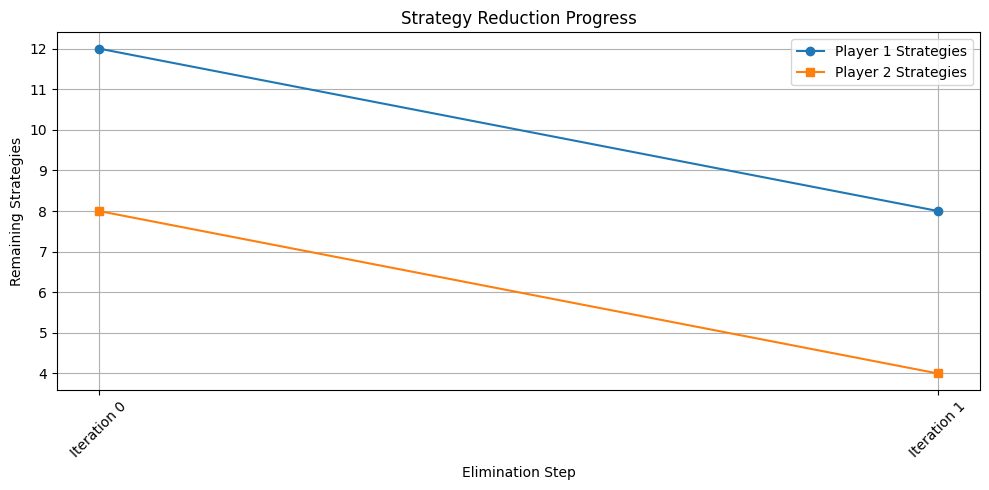

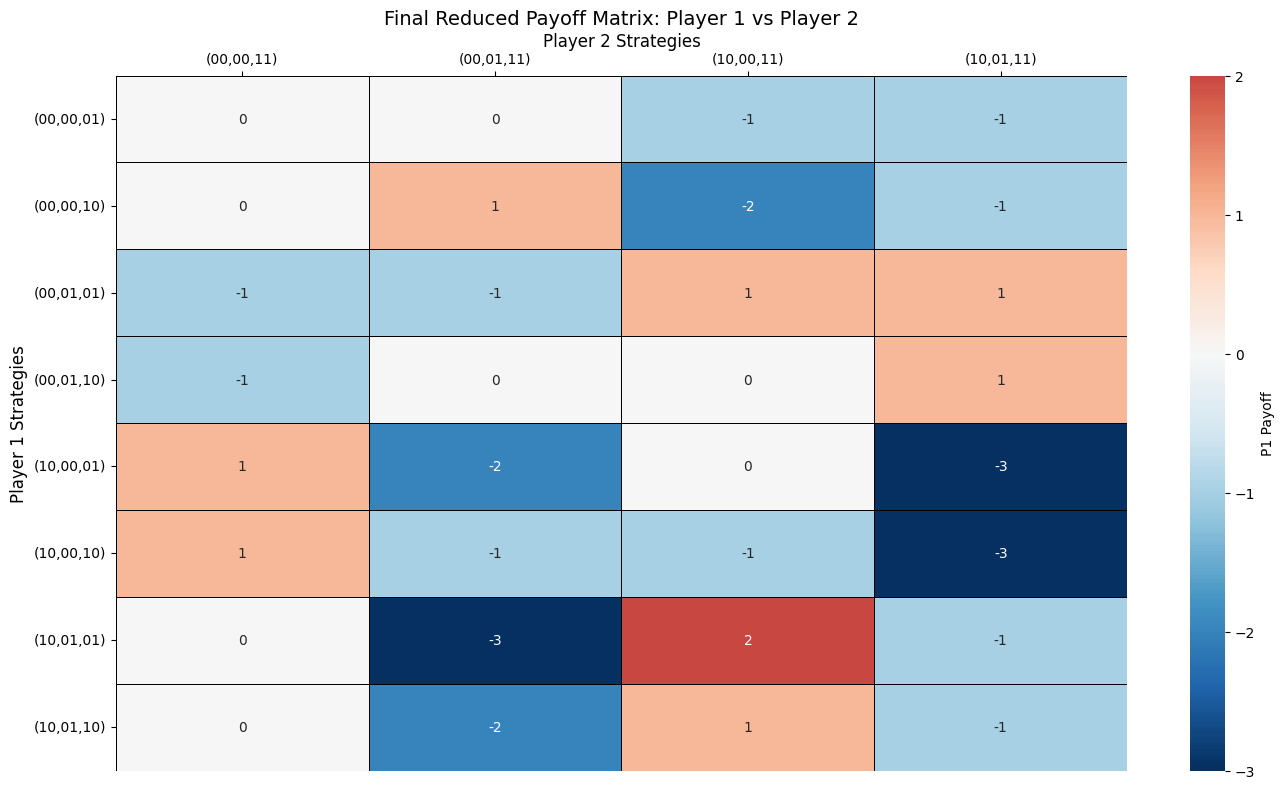

(array([[ 0.,  0., -1., -1.],
        [ 0.,  1., -2., -1.],
        [-1., -1.,  1.,  1.],
        [-1.,  0.,  0.,  1.],
        [ 1., -2.,  0., -3.],
        [ 1., -1., -1., -3.],
        [ 0., -3.,  2., -1.],
        [ 0., -2.,  1., -1.]]),
 ['(00,00,01)',
  '(00,00,10)',
  '(00,01,01)',
  '(00,01,10)',
  '(10,00,01)',
  '(10,00,10)',
  '(10,01,01)',
  '(10,01,10)'],
 ['(00,00,11)', '(00,01,11)', '(10,00,11)', '(10,01,11)'])

In [673]:
demonstrate_matrix_reduction()

In [674]:
analyzer = KuhnPokerMatrixAnalyzer()
full_matrix, p1_strategies, p1_names, p2_strategies, p2_names = analyzer.build_full_matrix()

print("Initial matrix size:", full_matrix.shape)
print("Player 1 strategies:", len(p1_names))
print("Player 2 strategies:", len(p2_names))

# Apply iterative elimination
final_matrix, surviving_p1, surviving_p2 = iterative_elimination(full_matrix, p1_names, p2_names)

print("\nFinal Reduced Matrix Size:", final_matrix.shape)
print("Surviving Player 1 strategies:", surviving_p1)
print("Surviving Player 2 strategies:", surviving_p2)



Initial matrix size: (27, 64)
Player 1 strategies: 27
Player 2 strategies: 64

--- Iteration 0 ---
Matrix shape: (27, 64)

--- Iteration 1 ---
Matrix shape: (12, 4)

--- Iteration 2 ---
Matrix shape: (8, 4)

No more dominated strategies. Stopping.

Final Reduced Matrix Size: (8, 4)
Surviving Player 1 strategies: ['(00,00,01)', '(00,00,10)', '(00,01,01)', '(00,01,10)', '(10,00,01)', '(10,00,10)', '(10,01,01)', '(10,01,10)']
Surviving Player 2 strategies: ['(00,00,11)', '(00,01,11)', '(10,00,11)', '(10,01,11)']


In [675]:
import nashpy as nash

# Payoff matrix for Player I (row player)
A = np.array([
    [0, 0, 1, 1],
    [0, -1, 2, 1],
    [1, 1, -1, -1],
    [1, 0, 0, -1],
    [-1, 2, 0, 3],
    [-1, 1, 1, 3],
    [0, 3, -2, 1],
    [0, 2, -1, 1]
])

# Since it's zero-sum, Player II's payoff is -A
B = -A

# Create the game
game = nash.Game(A, B)

# Compute Nash Equilibrium
equilibria = list(game.support_enumeration())

# Print all Nash Equilibria
for i, (x, y) in enumerate(equilibria):
    print(f"Equilibrium {i + 1}:")
    print(f"Player I's strategy: {x}")
    print(f"Player II's strategy: {y}")
    print()

Equilibrium 1:
Player I's strategy: [ 0.         -0.          0.          0.66666667 -0.          0.33333333
  0.          0.        ]
Player II's strategy: [0.66666667 0.         0.         0.33333333]

Equilibrium 2:
Player I's strategy: [0.55555556 0.         0.         0.33333333 0.         0.
 0.11111111 0.        ]
Player II's strategy: [0.33333333 0.33333333 0.33333333 0.        ]

Equilibrium 3:
Player I's strategy: [0.         0.4        0.46666667 0.         0.13333333 0.
 0.         0.        ]
Player II's strategy: [0.33333333 0.33333333 0.33333333 0.        ]

Equilibrium 4:
Player I's strategy: [ 0.          0.44444444  0.33333333  0.         -0.          0.
  0.          0.22222222]
Player II's strategy: [0.33333333 0.33333333 0.33333333 0.        ]

Equilibrium 5:
Player I's strategy: [0.         0.16666667 0.         0.58333333 0.25       0.
 0.         0.        ]
Player II's strategy: [0.33333333 0.33333333 0.33333333 0.        ]

Equilibrium 6:
Player I's strategy: 

c:\Python312\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (6) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


In [676]:
A = np.array([
            [58, 79],  # Server serves Left: wins 30% vs Left defense, 80% vs Right defense
            [73, 49]   # Server serves Right: wins 90% vs Left defense, 20% vs Right defense
        ])
B = np.array([
        [42, 21],  # Receiver defends Left: loses 30% vs Left serve, 10% vs Right serve
        [27, 51]   # Receiver defends Right: loses 80% vs Left serve, 20% vs Right serve
    ])

# Create the game
game = nash.Game(A, B)

# Compute Nash Equilibrium
equilibria = list(game.support_enumeration())

# Print all Nash Equilibria
for i, (x, y) in enumerate(equilibria):
    print(f"Equilibrium {i + 1}:")
    print(f"Player I's strategy: {x}")
    print(f"Player II's strategy: {y}")
    print()

Equilibrium 1:
Player I's strategy: [0.53333333 0.46666667]
Player II's strategy: [0.66666667 0.33333333]



In [677]:
class Strategy:
    """
    Represents a strategy for Kuhn Poker.
    Each strategy is defined by probabilities for each decision point.
    """
    def __init__(self, player_id: int, probabilities=None, dominant: bool = False):
        self.player_id = player_id  # 1 or 2
        if probabilities is None:
            # Initialize with random valid probabilities
            if dominant:
                self.probabilities = self._generate_random_dominant_strategy()
            else:
                # Generate a random valid strategy
                self.probabilities = self._generate_random_strategy()
        else:
            self.probabilities = probabilities
            
    def _generate_random_dominant_strategy(self) -> Dict[str, float]:
        """Generate a random dominant strategy for this player"""
        strategy = {}
        
        if self.player_id == 1:
            # Player 1 
            strategy['P1_initial_K_bet'] = random.random()
            strategy['P1_initial_Q_bet'] = 0.0
            strategy['P1_initial_J_bet'] = random.random()
            
            
            strategy['P1_respond_K_call'] = 1.0
            strategy['P1_respond_Q_call'] = random.random()
            strategy['P1_respond_J_call'] = 0.0
        
        elif self.player_id == 2:
            # Player 2 always bets after check
            strategy['P2_after_check_K_bet'] = 1.0
            strategy['P2_after_check_Q_bet'] = 0.0
            strategy['P2_after_check_J_bet'] = random.random()
            
            # Player 2 always calls after bet
            strategy['P2_after_bet_K_call'] = 1.0
            strategy['P2_after_bet_Q_call'] = random.random()
            strategy['P2_after_bet_J_call'] = 0.0
        
        return strategy
    

    def _generate_random_strategy(self) -> Dict[str, float]:
        """Generate a random valid strategy for this player"""
        strategy = {}
        
        if self.player_id == 1:
            # Player 1 initial actions (check/bet) for each card
            for card in ['K', 'Q', 'J']:
                strategy[f'P1_initial_{card}_bet'] = random.random()
            
            # Player 1 response to bet after checking (fold/call) for each card
            for card in ['K', 'Q', 'J']:
                strategy[f'P1_respond_{card}_call'] = random.random()
        
        elif self.player_id == 2:
            # Player 2 response to check (check/bet) for each card
            for card in ['K', 'Q', 'J']:
                strategy[f'P2_after_check_{card}_bet'] = random.random()
            
            # Player 2 response to bet (fold/call) for each card
            for card in ['K', 'Q', 'J']:
                strategy[f'P2_after_bet_{card}_call'] = random.random()
        
        return strategy
    
    def _validate_strategy(self):
        """Ensure all probabilities are between 0 and 1"""
        for key, prob in self.probabilities.items():
            if not (0 <= prob <= 1):
                raise ValueError(f"Invalid probability {prob} for {key}")


    def get_prob(self, key: str) -> float:
        """Get probability for a given situation and card"""
        return self.probabilities.get(key, 0.0)
    
    
    


In [678]:
class KuhnPokerGame:
    """
    Implements Kuhn Poker game mechanics.
    """
    CARDS = ['K', 'Q', 'J']
    CARD_VALUES = {'K': 3, 'Q': 2, 'J': 1}
    
    def __init__(self, strategy1: Strategy, strategy2: Strategy):
        self.strategy1 = strategy1  # Player 1's strategy
        self.strategy2 = strategy2  # Player 2's strategy
        self.reset_game()
    
    def reset_game(self):
        """Deal new cards and reset pot"""
        deck = self.CARDS.copy()
        random.shuffle(deck)
        self.player1_card = deck[0]
        self.player2_card = deck[1]
        self.pot = 2  # Each player antes 1
        self.player1_contribution = 1
        self.player2_contribution = 1
    
    def calculate_expected_payoff(self) -> tuple[float, float]:
        """
        Calculate the exact expected payoff for both players.
        Returns (expected_p1_payoff, expected_p2_payoff)
        """
        total_p1 = 0
        total_p2 = 0
        deals = list(permutations(self.CARDS, 2))  # All 6 card combinations
        
        for p1_card, p2_card in deals:
            p1_payoff, p2_payoff = self._evaluate_deal(p1_card, p2_card)
            total_p1 += p1_payoff
            total_p2 += p2_payoff

        # Divide by number of deals (6) to get average expected payoff
        return total_p1 / len(deals), total_p2 / len(deals)

    def _evaluate_deal(self, p1_card: str, p2_card: str) -> tuple[float, float]:
        """
        Compute expected payoff for one specific card deal.
        """
        pot = 2  # Both ante 1 unit
        p1_contribution = 1
        p2_contribution = 1

        # Player 1 acts first
        p1_check_prob = 1 - self.strategy1.get_prob(f'P1_initial_{p1_card}_bet')
        p1_bet_prob = self.strategy1.get_prob(f'P1_initial_{p1_card}_bet')

        check_path_p1 = 0
        check_path_p2 = 0
        bet_path_p1 = 0
        bet_path_p2 = 0

        # --- Path 1: P1 Checks ---
        if p1_check_prob > 0:
            # P2 decides whether to bet or check after seeing a check
            p2_check_prob = 1 - self.strategy2.get_prob(f'P2_after_check_{p2_card}_bet')
            p2_bet_prob = self.strategy2.get_prob(f'P2_after_check_{p2_card}_bet')

            # Subpath: Both check → showdown
            check_weight = p1_check_prob * p2_check_prob
            if check_weight > 0:
                p1_val, p2_val = self._showdown(pot, p1_contribution, p2_contribution, p1_card, p2_card)
                check_path_p1 += check_weight * p1_val
                check_path_p2 += check_weight * p2_val

            # Subpath: P2 bets after check
            bet_after_check_weight = p1_check_prob * p2_bet_prob
            if bet_after_check_weight > 0:
                pot += 1
                p2_contribution += 1

                # P1 responds to bet
                p1_call_prob = self.strategy1.get_prob(f'P1_respond_{p1_card}_call')
                p1_fold_prob = 1 - p1_call_prob

                # Subsubpath: P1 folds
                fold_weight = bet_after_check_weight * p1_fold_prob
                if fold_weight > 0:
                    check_path_p1 += fold_weight * (-p1_contribution)
                    check_path_p2 += fold_weight * p1_contribution

                # Subsubpath: P1 calls
                call_weight = bet_after_check_weight * p1_call_prob
                if call_weight > 0:
                    pot += 1
                    p1_contribution += 1
                    p1_val, p2_val = self._showdown(pot, p1_contribution, p2_contribution, p1_card, p2_card)
                    check_path_p1 += call_weight * p1_val
                    check_path_p2 += call_weight * p2_val

        # Reset pot and contributions for betting path
        pot = 2  # Both ante 1 unit
        p1_contribution = 1
        p2_contribution = 1

        # --- Path 2: P1 Bets ---
        if p1_bet_prob > 0:
            pot += 1
            p1_contribution += 1

            # P2 responds to bet
            p2_call_prob = self.strategy2.get_prob(f'P2_after_bet_{p2_card}_call')
            p2_fold_prob = 1 - p2_call_prob

            # Subpath: P2 folds
            fold_weight = p1_bet_prob * p2_fold_prob
            if fold_weight > 0:
                bet_path_p1 += fold_weight * p2_contribution
                bet_path_p2 += fold_weight * (-p2_contribution)

            # Subpath: P2 calls
            call_weight = p1_bet_prob * p2_call_prob
            if call_weight > 0:
                pot += 1
                p2_contribution += 1
                p1_val, p2_val = self._showdown(pot, p1_contribution, p2_contribution, p1_card, p2_card)
                bet_path_p1 += call_weight * p1_val
                bet_path_p2 += call_weight * p2_val

        # print(f"Evaluating deal: P1 {p1_card}, P2 {p2_card}")
        # print(f"Check path P1: {check_path_p1}, Check path P2: {check_path_p2}")
        # print(f"Bet path P1: {bet_path_p1}, Bet path P2: {bet_path_p2}")
        # # Print expected payoffs for this deal
        # print(f"Expected Payoff P1: {check_path_p1 + bet_path_p1}, P2: {check_path_p2 + bet_path_p2}")
        # Total expected payoff for this deal
        return check_path_p1 + bet_path_p1, check_path_p2 + bet_path_p2


    def _showdown(self, pot: int, p1_contribution: int, p2_contribution: int,
                  p1_card: str, p2_card: str) -> tuple[float, float]:
        """Return payoff based on card comparison"""
        if self.CARD_VALUES[p1_card] > self.CARD_VALUES[p2_card]:
            return pot - p1_contribution, -p2_contribution
        elif self.CARD_VALUES[p2_card] > self.CARD_VALUES[p1_card]:
            return -p1_contribution, pot - p2_contribution
        else:
            return 0, 0 


    def play_hand(self) -> Tuple[int, int]:
        """
        Play a complete hand and return (player1_payoff, player2_payoff)
        """
        self.reset_game()
        
        # Player 1 acts first
        p1_action = self.strategy1.get_action('initial', self.player1_card)
        
        if p1_action == 'CHECK':
            return self._handle_p1_check()
        elif p1_action == 'BET':
            return self._handle_p1_bet()
        else:
            raise ValueError(f"Invalid P1 initial action: {p1_action}")
    
    def _handle_p1_check(self) -> Tuple[int, int]:
        """Handle game flow when P1 checks initially"""
        # Player 2 responds to check
        p2_action = self.strategy2.get_action('after_check', self.player2_card)
        
        if p2_action == 'CHECK':
            # Both check, go to showdown
            return self._resolve_showdown()
        elif p2_action == 'BET':
            # P2 bets after P1 check, P1 must respond
            self.pot += 1
            self.player2_contribution += 1
            
            p1_response = self.strategy1.get_action('respond', self.player1_card)
            
            if p1_response == 'FOLD':
                # P1 folds, P2 wins pot
                return (-self.player1_contribution, self.player1_contribution)
            elif p1_response == 'CALL':
                # P1 calls, go to showdown
                self.pot += 1
                self.player1_contribution += 1
                return self._resolve_showdown()
            else:
                raise ValueError(f"Invalid P1 response: {p1_response}")
        else:
            raise ValueError(f"Invalid P2 action after check: {p2_action}")
    
    def _handle_p1_bet(self) -> Tuple[int, int]:
        """Handle game flow when P1 bets initially"""
        self.pot += 1
        self.player1_contribution += 1
        
        # Player 2 responds to bet
        p2_action = self.strategy2.get_action('after_bet', self.player2_card)
        
        if p2_action == 'FOLD':
            # P2 folds, P1 wins pot
            return (self.player2_contribution, -self.player2_contribution)
        elif p2_action == 'CALL':
            # P2 calls, go to showdown
            self.pot += 1
            self.player2_contribution += 1
            return self._resolve_showdown()
        else:
            raise ValueError(f"Invalid P2 response to bet: {p2_action}")
    
    def _resolve_showdown(self) -> Tuple[int, int]:
        """Resolve showdown and return payoffs"""
        p1_value = self.CARD_VALUES[self.player1_card]
        p2_value = self.CARD_VALUES[self.player2_card]
                
        if p1_value > p2_value:
            # Player 1 wins
            return (self.player2_contribution, -self.player2_contribution)
        elif p2_value > p1_value:
            # Player 2 wins
            return (-self.player1_contribution, self.player1_contribution)
        else:
            # Tie (shouldn't happen in Kuhn poker with different cards)
            return (0, 0)

In [679]:
class TennisGame:
    """
    Simple Tennis Game base model to demonstrate mixed strategies.
    Server chooses Left/Right, Receiver chooses Left/Right to defend.
    """
    def __init__(self, strategy1, strategy2):
        # Payoff matrix for Server (rows: Server actions, cols: Receiver actions)
        # [Server Left, Server Right] vs [Receiver Left, Receiver Right]
        self.A = np.array([
            [58, 79],  # Server serves Left: wins 30% vs Left defense, 80% vs Right defense
            [73, 49]   # Server serves Right: wins 90% vs Left defense, 20% vs Right defense
        ])
        self.B = np.array([
            [42, 21],  # Receiver defends Left: loses 30% vs Left serve, 10% vs Right serve
            [27, 51]   # Receiver defends Right: loses 80% vs Left serve, 20% vs Right serve
        ])
        self.strategy1 = strategy1
        self.strategy2 = strategy2
    
    def calculate_expected_payoff(self):
        """Calculate payoff for Server given actions"""
        expected_payoff_A = 0.0
        for i in range(2):  # Server actions
            for j in range(2):  # Receiver actions
                prob = self.strategy1.probabilities[i] * self.strategy2[j]
                expected_payoff_A += prob * self.A[i, j]

        expected_payoff_B = 0.0
        
        for i in range(2):
            for j in range(2):
                prob = self.strategy1[i] * self.strategy2[j]
                expected_payoff_B += prob * self.B[i, j]
        return expected_payoff_A, expected_payoff_B

In [680]:
def simulate_games(strategy1: Strategy, strategy2: Strategy, num_games: int = 1000) -> Dict[str, float]:
    """
    Simulate multiple games between two strategies and return statistics.
    """
    game = KuhnPokerGame(strategy1, strategy2)
    
   
    p1_payoff, p2_payoff = game.calculate_expected_payoff()
  
    
    return {
        'p1_average': p1_payoff,
        'p2_average': p2_payoff,
        'games_played': num_games
    }

In [681]:
def logit(x):
        return math.log(x / (1 - x)) if 0 < x < 1 else (-math.inf if x == 0 else math.inf)

def inverse_logit(x):
    return 1 / (1 + math.exp(-x))

class EvolutionaryAlgorithm:
    """
    Coevolutionary algorithm for evolving Kuhn Poker strategies.
    Player 1 and Player 2 populations evolve separately against each other.
    """
    def __init__(self, population_size=100, mutation_rate=0.1, crossover_rate=0.8, 
                 tournament_size=5, games_per_match=500, evaluation_sample_size=20, exploitability_lambda=0.5, hall_of_fame_size=500):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.games_per_match = games_per_match
        self.exploitability_lambda = exploitability_lambda  # Lambda for exploitability adjustment
        self.evaluation_sample_size = evaluation_sample_size  # How many opponents to test against
        
        self.hall_of_fame_size = hall_of_fame_size  # Size of hall of fame for each player

        # Hall of Fame - stores historically strong strategies
        self.p1_hall_of_fame = []
        self.p2_hall_of_fame = []

        # Initialize separate populations for each player
        self.player1_population = [Strategy(1, dominant=False) for _ in range(population_size)]
        self.player2_population = [Strategy(2, dominant=False) for _ in range(population_size)]
        
        # Fitness scores for each population
        self.player1_fitness = [0.0] * population_size
        self.player2_fitness = [0.0] * population_size
        
        # Statistics tracking
        self.generation = 0
        self.p1_best_fitness_history = []
        self.p2_best_fitness_history = []
        self.p1_avg_fitness_history = []
        self.p2_avg_fitness_history = []
        
    def evaluate_populations(self, verbose=False):
        """
        Evaluate both populations by having them compete against each other.
        Each individual is tested against a sample of opponents from the other population.
        """
        if verbose:
            print(f"  Evaluating populations...")
        
        # Reset fitness scores
        self.player1_fitness = [0.0] * self.population_size
        self.player2_fitness = [0.0] * self.population_size

        # Evaluate Player 1 population against Player 2 population
        for i, p1_strategy in enumerate(self.player1_population):
            # Sample random opponents from Player 2 population
            p2_opponents = random.sample(self.player2_population, 
                                       min(self.evaluation_sample_size, len(self.player2_population)))
            
            total_p1_payoff = 0
            for p2_strategy in p2_opponents:
                match_result = simulate_games(p1_strategy, p2_strategy, self.games_per_match)
                total_p1_payoff += match_result['p1_average']
            
            # Average payoff against sampled opponents
            self.player1_fitness[i] = total_p1_payoff / len(p2_opponents)
        
        # Evaluate Player 2 population against Player 1 population
        for i, p2_strategy in enumerate(self.player2_population):
            # Sample random opponents from Player 1 population
            p1_opponents = random.sample(self.player1_population, 
                                       min(self.evaluation_sample_size, len(self.player1_population)))
            
            total_p2_payoff = 0
            for p1_strategy in p1_opponents:
                match_result = simulate_games(p1_strategy, p2_strategy, self.games_per_match)
                total_p2_payoff += match_result['p2_average']
            
            # Average payoff against sampled opponents
            self.player2_fitness[i] = total_p2_payoff / len(p1_opponents)
        
        if self.exploitability_lambda > 0:
            # Compute exploitability for each strategy
            for i, p1_strategy in enumerate(self.player1_population):
            
                exploitability = self.compute_exploitability(p1_strategy, self.player2_population)
                self.player1_fitness[i] -= self.exploitability_lambda * exploitability  # Adjust lambda as needed

            # Compute exploitability for each strategy
            for i, p2_strategy in enumerate(self.player2_population):
            
                exploitability = self.compute_exploitability(p2_strategy, self.player1_population)
                self.player2_fitness[i] -= self.exploitability_lambda * exploitability 


        self.update_hall_of_fame()  # Update hall of fame with current best strategies
        # Update statistics
        self.p1_best_fitness_history.append(max(self.player1_fitness))
        self.p2_best_fitness_history.append(max(self.player2_fitness))
        self.p1_avg_fitness_history.append(sum(self.player1_fitness) / len(self.player1_fitness))
        self.p2_avg_fitness_history.append(sum(self.player2_fitness) / len(self.player2_fitness))
 

    def compute_exploitability(self, strategy, opponent_population):
        """Estimate exploitability by finding the best counter-strategy."""
        # Find the opponent that maximizes their payoff against this strategy (best response)
        best_response_opponent = None
        best_response_payoff = -float('inf')
        
        for opponent in opponent_population:
            payoff = simulate_games(strategy, opponent, self.games_per_match)['p2_average']
            if payoff > best_response_payoff:
                best_response_payoff = payoff
                best_response_opponent = opponent
        
        # Exploitability = how much the best-response opponent gains above the baseline
        baseline_payoff = self.estimate_baseline()  # Avg payoff of population vs itself
        return best_response_payoff - baseline_payoff

    def estimate_baseline(self):
        """Estimate the baseline payoff (e.g., average payoff of population vs itself)."""
        total_payoff = 0.0
        num_samples = min(20, len(self.player1_population))  # Sample to save computation
        for p1, p2 in zip(random.sample(self.player1_population, num_samples), 
                        random.sample(self.player2_population, num_samples)):
            total_payoff += simulate_games(p1, p2, self.games_per_match)['p1_average']
        return total_payoff / num_samples


    def update_hall_of_fame(self):
        """Update hall of fame with current best strategies."""
        # Get current best strategies
        best_p1_idx = max(range(self.population_size), key=lambda i: self.player1_fitness[i])
        best_p2_idx = max(range(self.population_size), key=lambda i: self.player2_fitness[i])
        
        best_p1 = Strategy(1, self.player1_population[best_p1_idx].probabilities.copy())
        best_p2 = Strategy(2, self.player2_population[best_p2_idx].probabilities.copy())
        
        # Add to hall of fame
        self.p1_hall_of_fame.append(best_p1)
        self.p2_hall_of_fame.append(best_p2)
        
        # Trim hall of fame to maximum size
        if len(self.p1_hall_of_fame) > self.hall_of_fame_size:
            self.p1_hall_of_fame.pop(0)
        if len(self.p2_hall_of_fame) > self.hall_of_fame_size:
            self.p2_hall_of_fame.pop(0)


    def tournament_selection(self, population: List[Strategy], fitness_scores: List[float]) -> Strategy:
        """
        Select a strategy using tournament selection.
        """
        # Randomly select tournament participants
        tournament_indices = random.sample(range(len(population)), self.tournament_size)
        
        # Find the best performer in the tournament
        best_index = max(tournament_indices, key=lambda i: fitness_scores[i])
        return population[best_index]
    
    def crossover(self, parent1: Strategy, parent2: Strategy) -> Tuple[Strategy, Strategy]:
        """
        Create two offspring through crossover of parent strategies.
        """
        if random.random() > self.crossover_rate:
            return Strategy(parent1.player_id, parent1.probabilities.copy()), \
                Strategy(parent2.player_id, parent2.probabilities.copy())
        
        child1_probs = {}
        child2_probs = {}
        for key in parent1.probabilities:
            if random.random() < 0.5:
                child1_probs[key] = parent1.probabilities[key]
                child2_probs[key] = parent2.probabilities[key]
            else:
                child1_probs[key] = parent2.probabilities[key]
                child2_probs[key] = parent1.probabilities[key]
        return Strategy(parent1.player_id, child1_probs), Strategy(parent2.player_id, child2_probs)
        
    


    def mutate(self, strategy: Strategy) -> Strategy:
        """
        Mutate a strategy by adding Gaussian noise to probabilities.
        """
        probs = strategy.probabilities.copy()
        for key in probs:
            if random.random() < self.mutation_rate:
                l = logit(probs[key])
                l += random.gauss(0, 0.2)  # Tune this scale
                probs[key] = inverse_logit(l)
        return Strategy(strategy.player_id, probs)
    
    def evolve_population(self, population: List[Strategy], fitness_scores: List[float]) -> List[Strategy]:
        """
        Create the next generation for one population through selection, crossover, and mutation.
        """
        new_population = []
        
        # Elitism: Keep the best strategy
        best_idx = max(range(len(population)), key=lambda i: fitness_scores[i])
        new_population.append(Strategy(population[0].player_id, population[best_idx].probabilities.copy()))
        
        while len(new_population) < self.population_size:
            # Select parents
            parent1 = self.tournament_selection(population, fitness_scores)
            parent2 = self.tournament_selection(population, fitness_scores)
            
            # Create offspring through crossover
            child1, child2 = self.crossover(parent1, parent2)
            
            # Mutate offspring
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            
            new_population.extend([child1, child2])
        
        # Trim to exact population size if necessary
        return new_population[:self.population_size]
    
    def get_best_strategies(self) -> Tuple[Strategy, Strategy, float, float]:
        """
        Return the best strategies from both populations and their fitness scores.
        """
        best_p1_idx = max(range(self.population_size), key=lambda i: self.player1_fitness[i])
        best_p2_idx = max(range(self.population_size), key=lambda i: self.player2_fitness[i])
        
        return (self.player1_population[best_p1_idx], self.player2_population[best_p2_idx],
                self.player1_fitness[best_p1_idx], self.player2_fitness[best_p2_idx])
    
    def run_coevolution(self, generations: int, verbose: bool = True):
        """
        Run the coevolutionary algorithm for specified number of generations.
        """
        print(f"Starting coevolution with population size {self.population_size} each")
        print(f"Running for {generations} generations...")
        print(f"Each individual tested against {self.evaluation_sample_size} opponents")
        print(f"Games per match: {self.games_per_match}\n")
        
        generation_history_p1 = []
        generation_history_p2 = []
        for gen in range(generations):
            if verbose:
                print(f"Generation {gen}:")
            
            # Evaluate both populations
            self.evaluate_populations(verbose=verbose)
            
            if verbose:
                p1_best = self.p1_best_fitness_history[-1]
                p2_best = self.p2_best_fitness_history[-1]
                p1_avg = self.p1_avg_fitness_history[-1]
                p2_avg = self.p2_avg_fitness_history[-1]
                print(f"  P1 - Best: {p1_best:7.4f}, Avg: {p1_avg:7.4f}")
                generation_history_p1.append(self.player1_population[0])
                print(f"best strategy1: {self.player1_population[0].probabilities}")
                print(f"  P2 - Best: {p2_best:7.4f}, Avg: {p2_avg:7.4f}")
                generation_history_p2.append(self.player2_population[0])
                print(f"best strategy2: {self.player2_population[0].probabilities}")
                print(f"  Game balance: {p1_best + p2_best:7.4f} (closer to 0 = more balanced)")
                print()
            
            # Evolve both populations
            if gen < generations - 1:  # Don't evolve after the last evaluation
                self.player1_population = self.evolve_population(self.player1_population, self.player1_fitness)
                self.player2_population = self.evolve_population(self.player2_population, self.player2_fitness)
                self.generation += 1
        
        # Final evaluation
        self.evaluate_populations()
        best_p1, best_p2, best_p1_fitness, best_p2_fitness = self.get_best_strategies()
        
        print(f"Coevolution completed!")
        print(f"Best P1 fitness: {best_p1_fitness:.4f}")
        print(f"Best P2 fitness: {best_p2_fitness:.4f}")
        print(f"Final balance: {best_p1_fitness + best_p2_fitness:.4f}")
        print(f"Generations run: {self.generation}")
        
        return best_p1, best_p2, best_p1_fitness, best_p2_fitness, generation_history_p1, generation_history_p2

In [682]:
print("\n=== Running Evolutionary Algorithm ===")
evo = EvolutionaryAlgorithm(
    population_size=200,    # Smaller for testing
    mutation_rate=0.08,
    crossover_rate=0.08,
    exploitability_lambda=0.0,
    games_per_match=1000  # Fewer games for faster testing
)

best_p1_a, best_p2_a, best_p1_fitness_a, best_p2_fitness_a, generation_p1_a, generation_p2_a = evo.run_coevolution(generations=300, verbose=True)


# Show evolution progress
print(f"\n=== Evolution Progress ===")
print(f"Best Player 1 Strategy: {best_p1_a.probabilities}")
print(f"Best Player 2 Strategy: {best_p2_a.probabilities}")
print(f"Best Player 1 Fitness: {best_p1_fitness_a:.4f}")
print(f"Best Player 2 Fitness: {best_p2_fitness_a:.4f}")



=== Running Evolutionary Algorithm ===
Starting coevolution with population size 200 each
Running for 300 generations...
Each individual tested against 20 opponents
Games per match: 1000

Generation 0:
  Evaluating populations...
  P1 - Best:  0.5344, Avg:  0.1113
best strategy1: {'P1_initial_K_bet': 0.4507498685964213, 'P1_initial_Q_bet': 0.945073008831241, 'P1_initial_J_bet': 0.32053518187123975, 'P1_respond_K_call': 0.946482473484384, 'P1_respond_Q_call': 0.09018702781407151, 'P1_respond_J_call': 0.9973898373893229}
  P2 - Best:  0.3147, Avg: -0.1053
best strategy2: {'P2_after_check_K_bet': 0.7537094720749576, 'P2_after_check_Q_bet': 0.38129539532990775, 'P2_after_check_J_bet': 0.03172068928998262, 'P2_after_bet_K_call': 0.01323798280456634, 'P2_after_bet_Q_call': 0.5498877472322039, 'P2_after_bet_J_call': 0.6921038279668961}
  Game balance:  0.8492 (closer to 0 = more balanced)

Generation 1:
  Evaluating populations...
  P1 - Best:  0.2002, Avg:  0.0316
best strategy1: {'P1_initi

In [683]:
# plot probabilities history
import matplotlib.pyplot as plt
def plot_probabilities(generation_p1, generation_p2):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    
    plt.suptitle('Evolution of Kuhn Poker Strategies, with exploitation')
    # Player 1: Initial bet probabilities
    axs[0, 0].plot(range(len(generation_p1)), [s.get_prob('P1_initial_K_bet') for s in generation_p1], label='K Bet')
    axs[0, 0].plot(range(len(generation_p1)), [s.get_prob('P1_initial_Q_bet') for s in generation_p1], label='Q Bet')
    axs[0, 0].plot(range(len(generation_p1)), [s.get_prob('P1_initial_J_bet') for s in generation_p1], label='J Bet')
    axs[0, 0].set_title('P1 Initial Bet Probabilities')
    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Probability')
    axs[0, 0].legend()

    # Player 2: After bet call probabilities
    axs[1, 0].plot(range(len(generation_p2)), [s.get_prob('P2_after_bet_K_call') for s in generation_p2], label='K Call')
    axs[1, 0].plot(range(len(generation_p2)), [s.get_prob('P2_after_bet_Q_call') for s in generation_p2], label='Q Call')
    axs[1, 0].plot(range(len(generation_p2)), [s.get_prob('P2_after_bet_J_call') for s in generation_p2], label='J Call')
    axs[1, 0].set_title('P2 After Bet Call Probabilities')
    axs[1, 0].set_xlabel('Generation')
    axs[1, 0].set_ylabel('Probability')
    axs[1, 0].legend()

    # Player 1: Respond call probabilities
    axs[0, 1].plot(range(len(generation_p1)), [s.get_prob('P1_respond_K_call') for s in generation_p1], label='K Call')
    axs[0, 1].plot(range(len(generation_p1)), [s.get_prob('P1_respond_Q_call') for s in generation_p1], label='Q Call')
    axs[0, 1].plot(range(len(generation_p1)), [s.get_prob('P1_respond_J_call') for s in generation_p1], label='J Call')
    axs[0, 1].set_title('P1 Respond Call Probabilities')
    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].legend()

    # Player 2: After check bet probabilities
    axs[1, 1].plot(range(len(generation_p2)), [s.get_prob('P2_after_check_K_bet') for s in generation_p2], label='K Bet')
    axs[1, 1].plot(range(len(generation_p2)), [s.get_prob('P2_after_check_Q_bet') for s in generation_p2], label='Q Bet')
    axs[1, 1].plot(range(len(generation_p2)), [s.get_prob('P2_after_check_J_bet') for s in generation_p2], label='J Bet')
    axs[1, 1].set_title('P2 After Check Bet Probabilities')
    axs[1, 1].set_xlabel('Generation')
    axs[1, 1].set_ylabel('Probability')
    axs[1, 1].legend()


    plt.tight_layout()

    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')

    plt.legend()



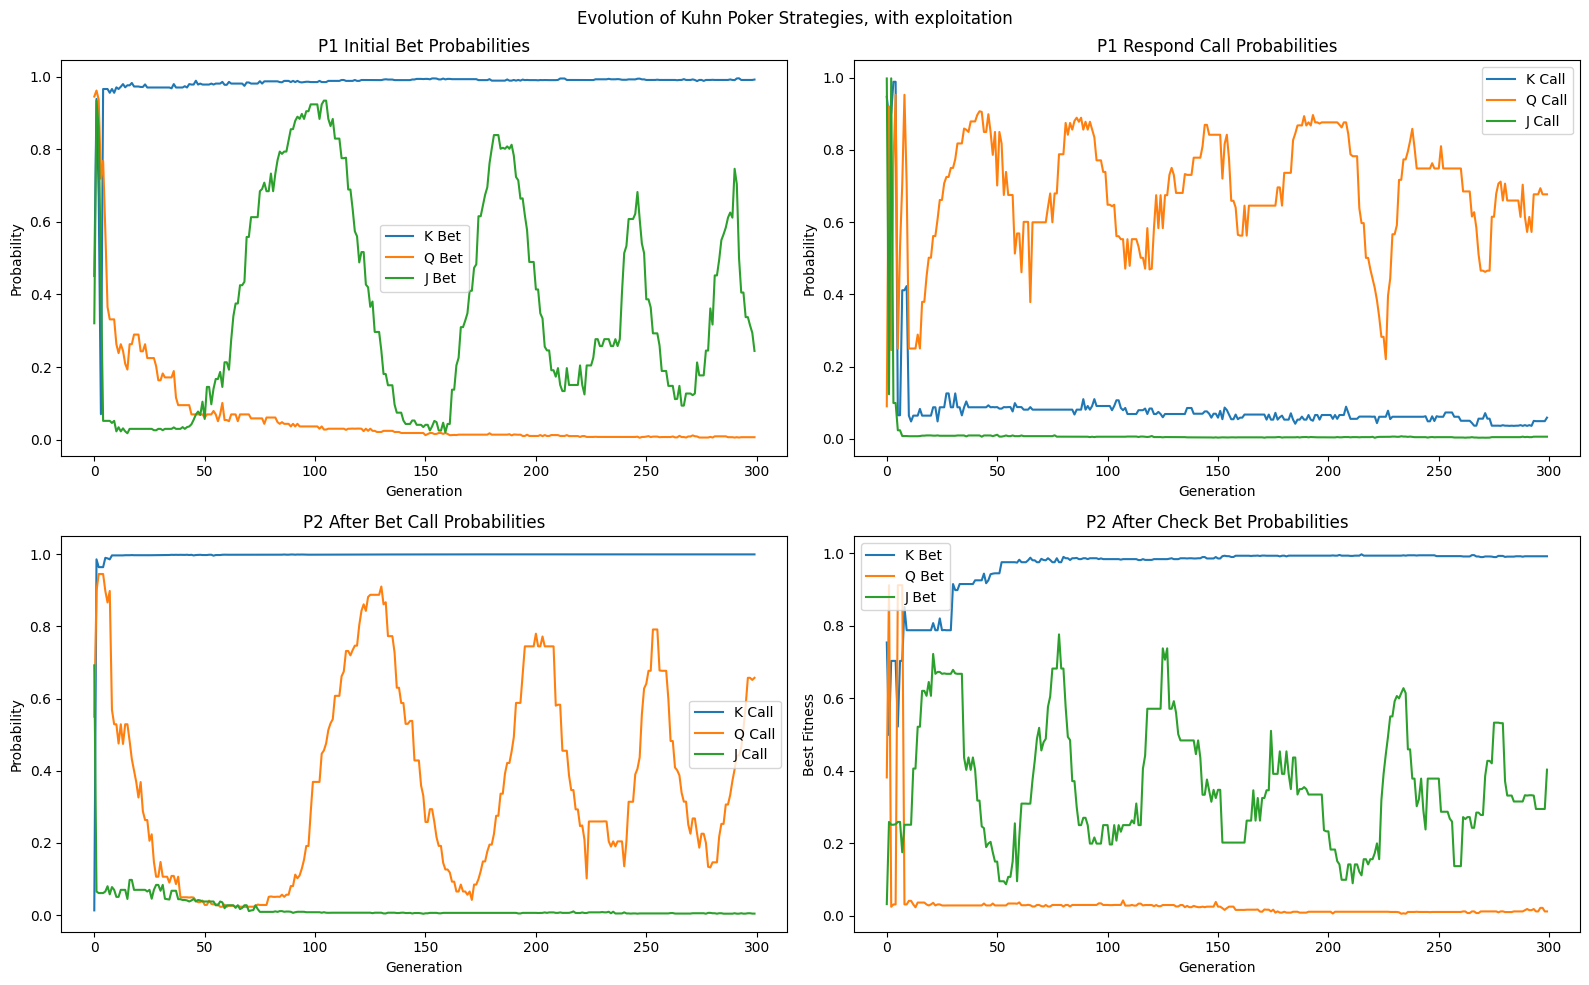

In [684]:
plot_probabilities(generation_p1_a, generation_p2_a)

With Exploitability factored in

In [ ]:
# Run evolutionary algorithm
print("\n=== Running Evolutionary Algorithm ===")
evo2 = EvolutionaryAlgorithm(
    population_size=200,    # Smaller for testing
    mutation_rate=0.08,
    crossover_rate=0.08,
    exploitability_lambda=0.5,
    games_per_match=1000  # Fewer games for faster testing
)

best_p1, best_p2, best_p1_fitness, best_p2_fitness, generation_p1, generation_p2 = evo2.run_coevolution(generations=200, verbose=True)


# Show evolution progress
print(f"\n=== Evolution Progress ===")
print(f"Best Player 1 Strategy: {best_p1.probabilities}")
print(f"Best Player 2 Strategy: {best_p2.probabilities}")
print(f"Best Player 1 Fitness: {best_p1_fitness:.4f}")
print(f"Best Player 2 Fitness: {best_p2_fitness:.4f}")



=== Running Evolutionary Algorithm ===
Starting coevolution with population size 200 each
Running for 200 generations...
Each individual tested against 20 opponents
Games per match: 1000

Generation 0:
  Evaluating populations...
  P1 - Best:  0.5294, Avg:  0.0146
best strategy1: {'P1_initial_K_bet': 0.2686198002773923, 'P1_initial_Q_bet': 0.11060815812910274, 'P1_initial_J_bet': 0.09664045870362348, 'P1_respond_K_call': 0.22428238284226643, 'P1_respond_Q_call': 0.45815664931126954, 'P1_respond_J_call': 0.5509781663836921}
  P2 - Best:  0.3541, Avg: -0.0525
best strategy2: {'P2_after_check_K_bet': 0.7122684907968581, 'P2_after_check_Q_bet': 0.3263673544628045, 'P2_after_check_J_bet': 0.27538052269106805, 'P2_after_bet_K_call': 0.34002555288860814, 'P2_after_bet_Q_call': 0.04420855395363954, 'P2_after_bet_J_call': 0.7823904863556567}
  Game balance:  0.8835 (closer to 0 = more balanced)

Generation 1:
  Evaluating populations...
  P1 - Best:  0.1584, Avg: -0.0203
best strategy1: {'P1_i

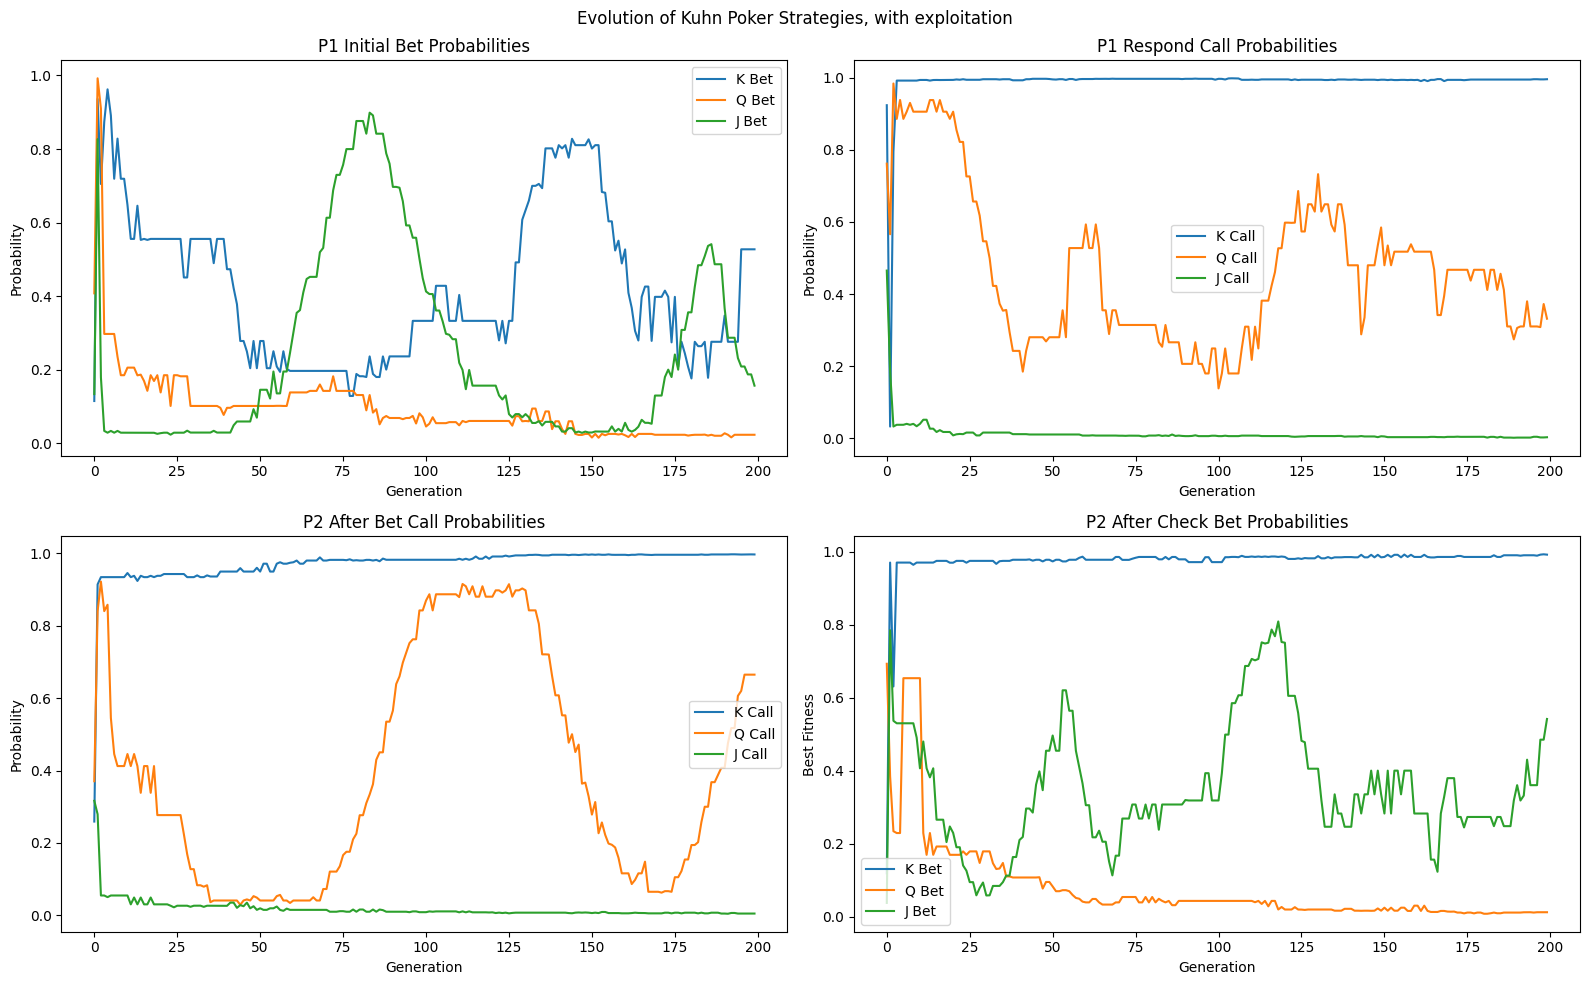

In [ ]:
plot_probabilities(generation_p1, generation_p2)

In [ ]:
# find median and mean of all different probabilities across the whole generation history

prob_keys = [
    'P1_initial_K_bet', 'P1_initial_Q_bet', 'P1_initial_J_bet',
    'P1_respond_K_call', 'P1_respond_Q_call', 'P1_respond_J_call',
    'P2_after_check_K_bet', 'P2_after_check_Q_bet', 'P2_after_check_J_bet',
    'P2_after_bet_K_call', 'P2_after_bet_Q_call', 'P2_after_bet_J_call'
]

median = {}
mean = {}

for key in prob_keys:
    values = [s.get_prob(key) for s in generation_p1 + generation_p2 if key in s.probabilities]
    if values:
        median[key] = np.median(values)
        mean[key] = np.mean(values)
    else:
        median[key] = None
        mean[key] = None


print("\n=== Median Probabilities ===")
for key, med in median.items():
    print(f"{key}: {med:.4f}")
print("\n=== Mean Probabilities ===")
for key, mean in mean.items():
    print(f"{key}: {mean:.4f}")



=== Median Probabilities ===
P1_initial_K_bet: 0.4423
P1_initial_Q_bet: 0.0316
P1_initial_J_bet: 0.1158
P1_respond_K_call: 0.9891
P1_respond_Q_call: 0.4348
P1_respond_J_call: 0.0011
P2_after_check_K_bet: 0.9961
P2_after_check_Q_bet: 0.0108
P2_after_check_J_bet: 0.3255
P2_after_bet_K_call: 0.9942
P2_after_bet_Q_call: 0.3097
P2_after_bet_J_call: 0.0085

=== Mean Probabilities ===
P1_initial_K_bet: 0.4813
P1_initial_Q_bet: 0.2589
P1_initial_J_bet: 0.1390
P1_respond_K_call: 0.9764
P1_respond_Q_call: 0.4076
P1_respond_J_call: 0.0095
P2_after_check_K_bet: 0.9959
P2_after_check_Q_bet: 0.0725
P2_after_check_J_bet: 0.3574
P2_after_bet_K_call: 0.9889
P2_after_bet_Q_call: 0.3684
P2_after_bet_J_call: 0.0241


In [ ]:

class MonteCarloNashAnalysis:
    """
    Monte Carlo analysis to measure how closely evolved strategies approximate Nash equilibria
    """
    
    def __init__(self, known_nash_strategy_p1=None, known_nash_strategy_p2=None):
        # Known Nash equilibrium for Kuhn Poker (if available)
        self.nash_p1 = known_nash_strategy_p1 or {
            'P1_J_bet': 1.0/3.0,
            'P1_Q_bet': 0.0, 
            'P1_K_bet': 1.0,
            'P1_after_bet_call_J': 0.0,
            'P1_after_bet_call_Q': 2.0/3.0,
            'P1_after_bet_call_K': 1.0
        }
        
        self.nash_p2 = known_nash_strategy_p2 or {
            'P2_after_check_K_bet': 1.0,
            'P2_after_check_Q_bet': 0.0,
            'P2_after_check_J_bet': 1.0/3.0,
            'P2_after_bet_K_call': 1.0,
            'P2_after_bet_Q_call': 1.0/3.0,
            'P2_after_bet_J_call': 0.0
        }
    
    def compute_strategy_distance(self, evolved_strategy, nash_strategy):
        """
        Compute L2 distance between evolved strategy and Nash equilibrium
        """
        distance = 0.0
        for key in nash_strategy:
            if key in evolved_strategy.probabilities:
                diff = evolved_strategy.probabilities[key] - nash_strategy[key]
                distance += diff ** 2
        return np.sqrt(distance)
    
    def monte_carlo_exploitability_test(self, strategy, opponent_population, 
                                      num_trials=100):
        """
        Monte Carlo estimation of strategy exploitability
        Returns distribution of exploitability scores
        """
        exploitability_scores = []
        
        for trial in range(num_trials):
            # Sample a random opponent
            opponent = random.choice(opponent_population)
            if opponent.player_id == 1:
            # Play games and measure exploitability
                result = simulate_games(opponent, strategy)
            else:
              result = simulate_games(strategy, opponent)
            
            # Exploitability = how much opponent gains above expected value
            expected_value = 0.0  # Zero-sum game expected value
            if opponent.player_id == 1:
                exploitability = abs(result['p1_average'] - expected_value)
            else:

                exploitability = abs(result['p2_average'] - expected_value)
            exploitability_scores.append(exploitability)
        
        return {
            'mean_exploitability': np.mean(exploitability_scores),
            'std_exploitability': np.std(exploitability_scores),
            'distribution': exploitability_scores,
            'confidence_interval_95': np.percentile(exploitability_scores, [2.5, 97.5])
        }
    
    def discover_mixed_strategy_continuum(self, evolved_populations, num_samples=10000):
        """
        Monte Carlo sampling to discover the continuum of mixed strategy equilibria
        """
        # Sample random combinations of evolved strategies
        strategy_combinations = []
        payoff_profiles = []
        
        for _ in range(num_samples):
            # Randomly sample strategies from evolved populations
            p1_strategy = random.choice(evolved_populations['player1'])
            p2_strategy = random.choice(evolved_populations['player2'])
            
            # Evaluate this combination
            result = simulate_games(p1_strategy, p2_strategy)
            
            strategy_combinations.append((p1_strategy, p2_strategy))
            payoff_profiles.append((result['p1_average'], result['p2_average']))
        
        return self._analyze_equilibrium_continuum(strategy_combinations, payoff_profiles)
    
    def _analyze_equilibrium_continuum(self, combinations, payoffs):
        """
        Analyze the discovered strategy combinations for equilibrium properties
        """
        payoffs = np.array(payoffs)
        
        # Find approximate equilibria (where both players have similar payoffs to Nash)
        nash_payoff_threshold = 0.05  # Tolerance for Nash-like payoffs
        
        equilibrium_candidates = []
        for i, (p1_payoff, p2_payoff) in enumerate(payoffs):
            # Check if this is close to zero-sum equilibrium
            if abs(p1_payoff + p2_payoff) < nash_payoff_threshold:
                equilibrium_candidates.append({
                    'index': i,
                    'p1_payoff': p1_payoff,
                    'p2_payoff': p2_payoff,
                    'strategies': combinations[i]
                })
        
        return {
            'total_combinations': len(combinations),
            'equilibrium_candidates': equilibrium_candidates,
            'payoff_distribution': payoffs,
            'equilibrium_diversity': len(equilibrium_candidates),
            'payoff_variance': np.var(payoffs, axis=0)
        }
    


def plot_nash_convergence_analysis(analysis_results):
    """
    Visualize the convergence to Nash equilibrium
    """
    fig, ((ax2, ax3)) = plt.subplots(1, 2, figsize=(12, 5))
    
   
    
    # Plot 2: Exploitability distribution
    if 'exploitability_p1' in analysis_results:
        ax2.hist(analysis_results['exploitability_p1']['distribution'], 
                bins=30, alpha=0.7, label='Player 1')
        ax2.hist(analysis_results['exploitability_p2']['distribution'], 
                bins=30, alpha=0.7, label='Player 2')
        ax2.set_xlabel('Exploitability Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Exploitability Distribution')
        ax2.legend()
    
    # Plot 3: Payoff profile scatter
    if 'equilibrium_analysis' in analysis_results:
        payoffs = analysis_results['equilibrium_analysis']['payoff_distribution']
        ax3.scatter(payoffs[:, 0], payoffs[:, 1], alpha=0.6)
        ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Player 2 Payoff')
        ax3.set_ylabel('Player 1 Payoff')
        ax3.set_title('Payoff Profile Distribution')
        ax3.grid(True)
    

    plt.tight_layout()
    return fig

# Example usage function
def run_comprehensive_monte_carlo_analysis(evo1, history_p1, history_p2):
    """
    Run a comprehensive Monte Carlo analysis of the evolutionary algorithm
    """
    print("Running comprehensive Monte Carlo analysis...")
    
    
    # Initialize analysis
    analyzer = MonteCarloNashAnalysis()
    

    # Analyze exploitability
    exploitability_p1 = analyzer.monte_carlo_exploitability_test(
        best_p1, evo1.p2_hall_of_fame
    )
    exploitability_p2 = analyzer.monte_carlo_exploitability_test(
        best_p2, evo1.p1_hall_of_fame
    )
    
    # Discover mixed strategy continuum
    equilibrium_analysis = analyzer.discover_mixed_strategy_continuum({
        'player1': evo1.player1_population,
        'player2': evo1.player2_population
    })
    
    results = {
        'exploitability_p1': exploitability_p1,
        'exploitability_p2': exploitability_p2,
        'equilibrium_analysis': equilibrium_analysis,
        'final_strategies': (best_p1, best_p2)
    }
  
    # Generate visualization
    plot_nash_convergence_analysis(results)
    
    return results

Running comprehensive Monte Carlo analysis...
{'mean_exploitability': np.float64(0.0825837644578557), 'std_exploitability': np.float64(0.056077953452641625), 'distribution': [0.08364663475102246, 0.1003223380101844, 0.00454439290986854, 0.11675576505041174, 0.012340058613331928, 0.10091791352436258, 0.09502115897906954, 0.017273986591552343, 0.11155887767072926, 0.10948214525384305, 0.02559496191072212, 0.12317036901469929, 0.011176381360212373, 0.10563177859249161, 0.11154328262087533, 0.21194160785212013, 0.005995384382094941, 0.11054915177913911, 0.2049422847157578, 0.10269066539624212, 0.014601408018052505, 0.02831326604500071, 0.006993198013753921, 0.10474547978910363, 0.02034471524248836, 0.09940263613726576, 0.12317036901469929, 0.11973109258750415, 0.11727374634743665, 0.09625576901219242, 0.1893007022759996, 0.09167536049744941, 0.09502115897906954, 0.1063123059253487, 0.014601408018052505, 0.017582231335328973, 0.17346854836827422, 0.07875905848809128, 0.08707078702751063, 0.

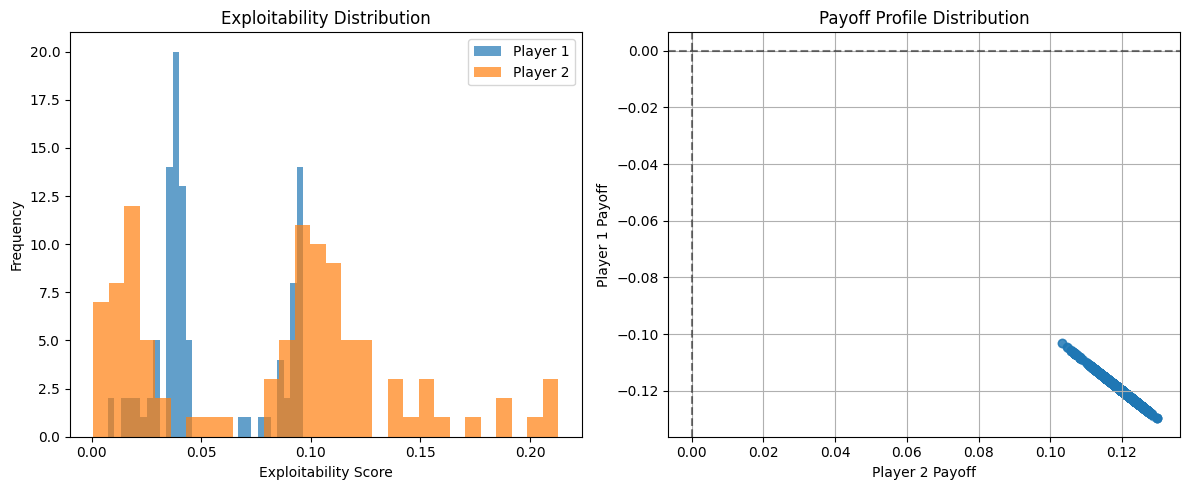

In [ ]:
results = run_comprehensive_monte_carlo_analysis(evo, generation_p1, generation_p2)
print(results['exploitability_p2'])